1 Preprocessing (20 pts)

Please leave your codes and results in the following sub-questions.


(a) First we will load the data using spark data source API. Write codes to load and print
out its schema using printSchema().

In [1]:
#from pyspark.mllib.stat import Statistics
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName('Spark Session 1').getOrCreate()
df = spark.read.csv('test.csv', header=True)

In [30]:
df_test = spark.read.csv('test.csv', header=True)
df_train = spark.read.csv('train.csv', header=True)
df_test.printSchema()
df_train.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



(b) Find columns that include Missing values. After that, fill the mean value for all the
missing values. Please drop Ticket and Cabin columns.

In [31]:
from pyspark.sql.functions import *
columns = set(df_test.columns) - set(['Ticket', 'Cabin'])
print(columns)
df_test = df_test.drop('Ticket')
df_test = df_test.drop('Cabin')

df_train = df_train.drop('Ticket')
df_train = df_train.drop('Cabin')
#df_train.where(null).show()

{'Embarked', 'Name', 'Fare', 'Pclass', 'SibSp', 'PassengerId', 'Parch', 'Sex', 'Age'}


In [32]:
def null_value_count(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows
            null_columns_counts.append(temp)
    return(null_columns_counts)

In [33]:
null_columns_count_list = null_value_count(df_train)
null_columns_count_list

[('Age', 177), ('Embarked', 2)]

In [34]:
#test
mean_Age_train = df_train.select(mean('Age')).collect()[0][0]
#mean_Embarked_train = df_train.select(mean('Embarked')).collect()[0][0]


In [35]:
import math

df_train = df_train.na.fill({"Age" : mean_Age_train})

In [36]:
df_train.groupBy('Embarked').count().collect()

[Row(Embarked='Q', count=77),
 Row(Embarked=None, count=2),
 Row(Embarked='C', count=168),
 Row(Embarked='S', count=644)]

In [37]:
df_train = df_train.na.fill({'Embarked': '0'})

(c) Visualize a histogram for an Age column.


In [38]:
toFloat = ['Survived', 'Age', 'PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare']

In [39]:
df_train.printSchema()

for col in toFloat:
    df_train = df_train.withColumn(col, df_train[col].cast("double").alias(col))


df_train.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = false)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Embarked: string (nullable = false)

root
 |-- PassengerId: double (nullable = true)
 |-- Survived: double (nullable = true)
 |-- Pclass: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: double (nullable = true)
 |-- Parch: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)



(array([ 54.,  46., 177., 346., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

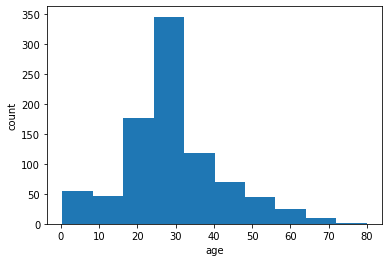

In [40]:
import matplotlib.pyplot as plt
import pyspark
from pyspark_dist_explore import hist

fig, ax = plt.subplots()
ax.set_xlabel('age')
ax.set_ylabel('count')
hist(ax, df_train.select('Age'))

(d) Many columns are categorical variables. So we use one-hot encoding using spark ML
pipeline API. In this example, we are using StringIndexer and OneHotEncoder to do
that

In [41]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [42]:
col_list = df_train.columns
col_list
df_train = df_train.drop('Name')
str_list = ['Sex', 'Embarked']

In [43]:
_stages = []
indexers = [StringIndexer(inputCols = [string for string in str_list], outputCols = [string+'_index' for string in str_list])]

encoders = [OneHotEncoder(inputCols = [string+'_index' for string in str_list], outputCols = [string+'_vec' for string in str_list])]

_stages += indexers
_stages += encoders
_stages

[StringIndexer_a716aae75a45, OneHotEncoder_8c325091adf9]

In [44]:
asm_input = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
asm_input += [string + '_index' for string in str_list]
vector_assembler = VectorAssembler(inputCols=asm_input, outputCol='features')
_stages += [vector_assembler]
_stages

[StringIndexer_a716aae75a45,
 OneHotEncoder_8c325091adf9,
 VectorAssembler_a77a7a4e9dcb]

In [45]:
pipeline = Pipeline(stages = _stages)

(e) One we prepared our data, we split the data into two sets: training (80 %) and testing
(20 %) datasets. We use Spark’s randomSplit method to get them. Please leave the
code.


In [46]:
train, test = df_train.randomSplit([0.8, 0.2])

In [47]:
print(train.count())
print(test.count())
print(test)
print(train)

696
195
DataFrame[PassengerId: double, Survived: double, Pclass: double, Sex: string, Age: double, SibSp: double, Parch: double, Fare: double, Embarked: string]
DataFrame[PassengerId: double, Survived: double, Pclass: double, Sex: string, Age: double, SibSp: double, Parch: double, Fare: double, Embarked: string]


2 Classification using Logistic Regression (20 pts)

In this questions below, you will train and test a logistic regression model. Please leave
your codes for each part in your report.


(a) Create stages for all features, which are processed above, and make a pipeline with
logistic regression using default parameters.


In [48]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

In [49]:
lr = LogisticRegression(labelCol='Survived', featuresCol = 'features')
_stages += [lr]
_stages

[StringIndexer_a716aae75a45,
 OneHotEncoder_8c325091adf9,
 VectorAssembler_a77a7a4e9dcb,
 LogisticRegression_13fe042b5307]

In [50]:
pipeline = Pipeline(stages = _stages)

(b) Fit the model.

In [51]:
model = pipeline.fit(train)
train_predict = model.transform(train).select('*')
train_predict

DataFrame[PassengerId: double, Survived: double, Pclass: double, Sex: string, Age: double, SibSp: double, Parch: double, Fare: double, Embarked: string, Sex_index: double, Embarked_index: double, Sex_vec: vector, Embarked_vec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

(c) Once model is trained, we need to know how it’s performing. So we use precision
score as our evaluation metric. Report the result. You can refer to RDD-Evaluation
or Precision with Micro option (Scikit-learn).

In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
test_predict = model.transform(test)

In [53]:
prediction = test_predict.select('PassengerId', 'probability', 'prediction')


In [54]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [55]:
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='accuracy')
print('train accuracy')
evaluator.evaluate(test_predict)

train accuracy


0.7692307692307693

In [56]:
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedPrecision')
print('test presicion')
evaluator.evaluate(test_predict)

test presicion


0.7696068376068377

(d) From the fitted model, please identify which attribute is contributed the most? (Hint:
Print the coefficients and intercepts for logistic regression.)


In [57]:
model.stages[-1].coefficients

DenseVector([0.0001, -1.1853, -0.0377, -0.2417, -0.0621, 0.001, 2.8228, 0.2864])

1: PassengerId
2: Pclass
3: Age
4: SibSp
5: Parch
6: Fare
7: Sex_index
8: Embarked_index


the correlation coefficient is related to feature importance. so, if the absolute value of the coefficient is large value not close to zero, it is importance feature of ML model. As a result, the Sex attribute is contributed the most in fitted model.